In [1]:
#Importing libraries
import pickle
import nltk
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
import sklearn.manifold
import numpy as np
import pandas as pd
import re
import multiprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import collections
from scipy import stats 
import numpy as np 

In [5]:
file = open("wiki.txt", "r",errors='ignore').read() 

In [6]:
print("Corpus is now {0} characters long".format(len(file)))

Corpus is now 94298560 characters long


In [7]:
#Split the corpus into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(file)

In [8]:
#convert into a list of words
#remove unnecessary, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean=re.sub('[\n]',' ',raw.lower())
    clean = re.sub("[^a-zA-Z]"," ", raw.lower())
    words = clean.split()
    #words = [ps.stem(w) for w in words if not w in stop_words]  
    words = [w for w in words if not w in stop_words] 
    return words

In [9]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
#print(sentences[1])

In [10]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 7,976,868 tokens


In [11]:
def getWordList(sentences,minCount):
    wordList = []
    count = Counter()
    for sentence in sentences:
        for word in sentence:
            count[word] += 1
    for word,c in count.items():
        if c >= minCount:
            wordList.append(word)
    return wordList

In [12]:
WordList=getWordList(sentences,minCount=5) # for min frequency of a word which should be 5
#print(WordList)

In [13]:
#Vocab Size
len(WordList)

23079

In [14]:

import itertools
ab=list(itertools.chain.from_iterable(sentences))
new_str =' '.join(ab)  
open('wiki_clean.txt', 'w').write(new_str) # writing clean text to new file

62960183

In [15]:
model1 = Word2Vec(sentences,size=300,window=5,min_count=5,seed=42,workers=multiprocessing.cpu_count(),batch_words=1) 

In [17]:
model2 = Word2Vec(sentences,size=300,window=5,min_count=5,seed=102,workers=multiprocessing.cpu_count(),batch_words=1) # the two embedding spaces

In [18]:
#word_frequency
w2c = dict()
for item in model1.wv.vocab:
    w2c[item]=model1.wv.vocab[item].count
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
# reverse output word and their frequency

In [19]:
def Stability(word,similar1,similar2):    
    overlap=0
    for i in range(len(similar1)):
        for j in range(len(similar2)):
            if similar1[i][0] == similar2[j][0]:
                overlap=overlap+1
    return overlap

In [20]:
start_time = time.process_time()
with open('swiki.csv', 'a',errors='replace') as the_file:
    the_file.write('Word,Stability(%),Stability(%) IU,Frequency\n')
    for word in WordList:
        similar1=model1.wv.most_similar(word, topn=10)
        similar2=model2.wv.most_similar(word, topn=10)
        stab=Stability(word,similar1,similar2)
        the_file.write(word+','+str(stab*10)+','+str(stab*100/(20-stab))+','+str(w2cSorted[word])+'\n')
print (time.process_time() - start_time, "seconds")

163.65625 seconds


In [22]:
df=pd.read_csv('swiki.csv')

In [44]:
df['Stability(%) IU'] = pd.to_numeric(df['Stability(%) IU'])
s = df['Stability(%) IU'].sum()
print(s)

738446.6209487107


In [23]:
df['Percentile Rank'] = df.Frequency.rank(pct = True)

In [24]:
df['Category'] = pd.cut(df['Percentile Rank'], bins = 5, labels = ["VL", "L", "M", "H", "VH"] )

In [25]:
df['Category'].value_counts()

VL    5555
H     4475
VH    4465
L     4295
M     4289
Name: Category, dtype: int64

In [26]:
df.head(100000)

,Word,Stability(%),Stability(%) IU,Frequency,Percentile Rank,Category
0,action,100,100.000000,9901,0.995364,VH
1,taken,80,66.666667,8199,0.993587,VH
2,parliament,80,66.666667,37171,0.999523,VH
3,resolutions,80,66.666667,1076,0.937692,VH
4,see,80,66.666667,11064,0.996144,VH
...,...,...,...,...,...,...
23074,disselkoen,20,11.111111,8,0.189480,VL
23075,mellau,30,17.647059,5,0.034989,VL
23076,nashiri,80,66.666667,18,0.406647,L
23077,eurosecurities,20,11.111111,6,0.098120,VL


In [27]:
grouped = df.groupby('Category')

In [28]:
grouped.sum()

,Stability(%),Stability(%) IU,Frequency,Percentile Rank
Category,,,,
VL,110190,67544.089425,36722,668.650721
L,110050,69590.099263,59423,1433.527666
M,168030,114952.713841,132533,2229.150093
H,263850,198917.848491,444168,3175.487456
VH,343000,287441.869929,7261183,4033.184063


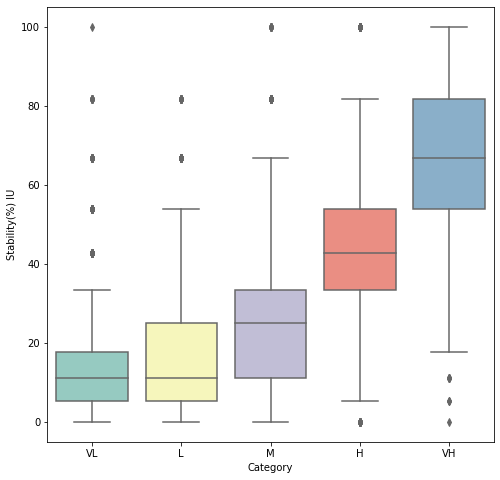

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(8, 8))
#sns.despine(f, left=True, bottom=True)
#category_ranking = ["VL", "L", "M", "H", "VH"]

ax=sns.boxplot(x="Category", y="Stability(%) IU", 
                 orient='v', 
                data=df, palette="Set3")

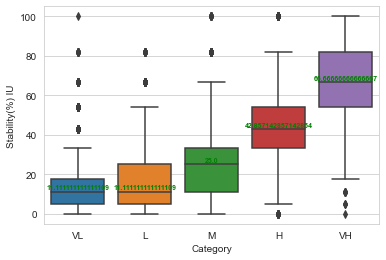

In [30]:
import seaborn as sns

sns.set_style("whitegrid")


box_plot = sns.boxplot(x="Category",y="Stability(%) IU",data=df)

medians = df.groupby(['Category'])['Stability(%) IU'].median()
vertical_offset = df['Stability(%) IU'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
        box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
        horizontalalignment='center',size='x-small',color='g',weight='semibold')

In [38]:
df.groupby(['Category'])['Stability(%) IU'].quantile([0.25,0.5,0.75])

Category      
VL        0.25     5.263158
          0.50    11.111111
          0.75    17.647059
L         0.25     5.263158
          0.50    11.111111
          0.75    25.000000
M         0.25    11.111111
          0.50    25.000000
          0.75    33.333333
H         0.25    33.333333
          0.50    42.857143
          0.75    53.846154
VH        0.25    53.846154
          0.50    66.666667
          0.75    81.818182
Name: Stability(%) IU, dtype: float64

In [39]:
sum_corr1=len(op1[-1]['correct'])
sum_incorr1=len(op1[-1]['incorrect'])
total1=sum_corr1+sum_incorr1
percent=lambda a: a/total1*100
percent(sum_corr1)

16.30413672557778

In [40]:
sum_corr2=len(op2[-1]['correct'])
sum_incorr2=len(op2[-1]['incorrect'])
total2=sum_corr2+sum_incorr2
percent=lambda a: a/total2*100
percent(sum_corr2)

17.15867158671587

In [41]:
with open('accuracy_wiki.csv', 'a',errors='replace') as the_file:
    the_file.write(str(percent(sum_corr1))+','+str(percent(sum_corr2))+'\n')